# Tweets EDA and Extract User Features
- UDD/MDS18/PP4
- Final Project: 'Studying Twitter User Accounts: Spotting Suspicious Social Bot Behavior'
- Master Candidate: Marcelo Rovai
- Professors:	   
    - Eduardo Graells-Garrido (Supervisor)
    - Loreto Bravo
    - Leo Ferres

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
import collections
from wordcloud import WordCloud
from stop_words import get_stop_words

In [139]:
STOPWORDS = get_stop_words('spanish')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

## Main Functions 

In [149]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='inferno',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

## Import Dataset

### Importing Tweet Dataset - .csv format

The original raw dataset: `10_raw_tweets_nov_2017.txt`,<br>
should be converted to:   `20_tweets_nov_2017.csv`, <br>
using the python script:
`10_read_twt_conv_csv.py` <br>

**Timeline**: The dataset covers 30 days (full November) of tweets generated “around” first round of 2017’s elections (November 19, 2017).

In [3]:
ls ../data/

20_tweets_nov_2017.csv        40_user_metrics.csv
30_tweets_nov_2017_final.csv


The converted file got error, the cause was that there were some carriage returns "\r" in the data that Pandas was using as a line terminator as if it was "\n". The solution found by [Louise Fallon](https://stackoverflow.com/users/7119676/louise-fallon), was to add lineterminator="\n" into the read_csv function.

In [5]:
tweets_data_path = "../data/20_tweets_nov_2017.csv"
tweets = pd.read_csv(tweets_data_path, lineterminator='\n')
tweets.shape

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1608086, 32)

### Cleaning dataset

In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608086 entries, 0 to 1608085
Data columns (total 32 columns):
Unnamed: 0            1608086 non-null int64
user_id               1608086 non-null int64
user                  1608086 non-null object
name                  1608019 non-null object
description           1383710 non-null object
verified              1608086 non-null bool
protected             1608086 non-null bool
location              1172584 non-null object
lang                  1608086 non-null object
followers             1608086 non-null int64
following             1608086 non-null int64
favourites            1608086 non-null int64
lists                 1608086 non-null int64
tweets_cnt            1608086 non-null int64
acc_creation          1608086 non-null object
default_profile       1608086 non-null bool
default_prof_image    1608086 non-null bool
image                 1608086 non-null object
notifications         0 non-null float64
text                  1608086 non

- Column 28 (coordinates) has very few data and also format issues. Should be deleted.
- Columns 'Unnamed:0' and 'notifications' have zero data and should be deleted

In [7]:
del tweets['coordinates']
del tweets['Unnamed: 0']
del tweets['notifications']

- Not all users fill 'description' and 'location' with data. So, empt data should be replaced with ''  

In [9]:
tweets.description.fillna('', inplace=True)

In [10]:
tweets.location.fillna('', inplace=True)

- Columns 'create_at' and 'acc_creation' should be at datatime format

In [12]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)
tweets['acc_creation'] = pd.to_datetime(tweets['acc_creation'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [13]:
tweets['created_at'].min()

Timestamp('2010-12-24 12:30:30+0000', tz='UTC')

In [20]:
len(tweets[tweets['created_at'] <= '2017-10-31'])

6441

In [14]:
tweets['created_at'].max()

Timestamp('2017-12-01 00:00:00+0000', tz='UTC')

In [18]:
len(tweets[tweets['created_at'] >= '2017-12-01'])

2

`There are 6,441 tweets older than November 1st and 2 from december 1st, 2017. Let's filter them:`

In [23]:
tweets = tweets[(tweets.created_at > '2017-10-31')
                & (tweets.created_at < '2017-12-01')]
len(tweets)

1601643

In [24]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1601643 entries, 0 to 1608084
Data columns (total 29 columns):
user_id               1601643 non-null int64
user                  1601643 non-null object
name                  1601576 non-null object
description           1601643 non-null object
verified              1601643 non-null bool
protected             1601643 non-null bool
location              1601643 non-null object
lang                  1601643 non-null object
followers             1601643 non-null int64
following             1601643 non-null int64
favourites            1601643 non-null int64
lists                 1601643 non-null int64
tweets_cnt            1601643 non-null int64
acc_creation          1601643 non-null datetime64[ns, UTC]
default_profile       1601643 non-null bool
default_prof_image    1601643 non-null bool
image                 1601643 non-null object
text                  1601643 non-null object
tweet_id              1601643 non-null int64
created_at     

In [25]:
tweets.head()

,user_id,user,name,description,verified,protected,location,lang,followers,following,...,created_at,lenght,retweet_cnt,favorite_cnt,reply_to_twt_id,reply_to_user,reply_to_user_id,device,RT,Reply
0,24952459,T13,Tele13,Cuenta oficial de las plataformas informativas...,True,False,"Santiago, Chile",es,2837484,111381,...,2017-10-31 01:59:13+00:00,137,89,51,nan,NaN,nan,-,False,NaN
1,2955687197,nostromar,Constanza Lewis,Defiendo a los animales del mundo y de mi país...,False,False,,es,3066,3386,...,2017-11-01 00:00:02+00:00,140,0,0,nan,NaN,nan,Android,True,NaN
2,883906441496735744,Chicavalpo,Chiquita,,False,False,,es,7,35,...,2017-11-01 00:00:03+00:00,109,0,0,925501623647977600,brayanlobos21,784110274630541312,Android,False,brayanlobos21
3,3015470117,corrupcionchile,Corrupción Chile,Medio Digital Libertario #Libertad #Economía #...,False,False,Chile,es,11737,9472,...,2017-11-01 00:00:03+00:00,130,0,0,nan,NaN,nan,-,False,NaN
4,82963099,abalosfelipe,Felipe Abalos,"Trabajando #PorUnChileMasJusto, Militante UDI,...",False,False,Chile,es,8431,3086,...,2017-10-31 23:41:54+00:00,139,8,6,nan,NaN,nan,Web,False,NaN


---

## Extracting additional features 

### Add basic text metrics

In [26]:
def retweet_from (row):
    try:
        if row['text'].find("RT") == 0:
            end = row['text'].find(":")
            return row['text'][3:end]
        else: return 0
    except:
        pass

In [27]:
tweets['retweet_from'] = tweets.apply(retweet_from, axis=1)

In [28]:
tw_len = tweets['lenght']

In [29]:
tw_len.describe()

count   1601643
mean        164
std          85
min          13
25%         127
50%         139
75%         189
max        1017
Name: lenght, dtype: float64

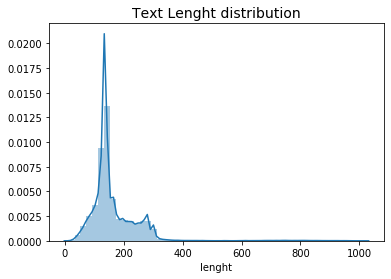

In [31]:
sns.distplot(tw_len);
plt.title("Text Lenght distribution", fontsize = 14);

In [39]:
len(tweets[tweets['lenght'] > 240])

233816

In [41]:
tweets['lenght'].max()

1017

In [44]:
tweets[tweets['lenght'] == 1017].text

840489    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
841111    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
841590    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
842104    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
847156    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
847864    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
881437    @MaryoryOrtizAl @Gral_McArthur @DarkPunisher00...
Name: text, dtype: object

In [45]:
tweets.text[840489]

'@MaryoryOrtizAl @Gral_McArthur @DarkPunisher00 @MonicaAparicioA @LibertadChile1 @niorvis_rivera @CriticaSinMiedo @ngotranslations @franciscoxloza @4gatoscuba @yolyhabanera @monnissima @FridaSiKahlo @Willywild6 @kicolegon @geopolytica @maestrociro @JuanaDeArcoFr @chileno_soy @monicacorrales @AbrahamTroncoso @CHC31 @omarbula @Csanchezberzain @realDonaldTrump @trafficMcbo @ResistenciaV58 @AlvaroUribeVel @JoseLuisExeni @NormaPierola @federicoalves @alopezescarre @ANDRES_CANO42 @rubiodelpozo @jdanielferrer @GerdLuders @ARMANDITOLIC @jaguerrerobta @AnjokaMaximo @JohanaZurima @aba261 @RH3927 @AndresPastrana_ @jorasquin @NoelGAbreu @LuisLazaroGuanc @ernestounpacu @alexeisunpacu @CarlosAMontaner @sebastianpinera Así como los paramilitares desangraron a Colombia las FARC ha desagrado este país por más de 50 años. Hoy todo el que no esta de acuerdo con esta mentira de Paz es tratado de paramilitar le informo que no lo soy ni apoyo ningún lado violento, y si creo en Dios el es la solución . https

`Regarding text length as expected, the average is 164 characters, being the median 139. What called the attention is that there are tweets that has more that 240 characters (15%). That’s happens due how Twitter apply its limits. For example, tweets with even thousands of characters were found, were dozens of mentions were posted with very few words. Those tweets could be generated by bot’s candidates. `

In [32]:
tweets['num_hashtags'] = tweets.apply(lambda x: x.text.count('#'), axis = 1)

In [33]:
hash_tweets = tweets[tweets['num_hashtags'] !=0]
print(f"The percentage of tweets with hashtags is {round(len(hash_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweets with hashtags is 28% of all the tweets


In [34]:
tweets['num_mentions'] = tweets.apply(lambda x: x.text.count('@'), axis = 1)

In [35]:
ment_tweets = tweets[tweets['num_mentions'] !=0]
print(f"The percentage of tweets with mentions is {round(len(ment_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweets with mentions is 74% of all the tweets


In [36]:
tweets['num_urls'] = tweets.apply(lambda x: x.text.count('http'), axis = 1)

In [37]:
tweets.num_urls.value_counts()

0    1007577
1     481040
2     112064
3        918
4         44
Name: num_urls, dtype: int64

In [38]:
url_tweets = tweets[tweets['num_urls'] !=0]
print(f"The percentage of tweets with Urls is {round(len(url_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweets with Urls is 37% of all the tweets


Let's verify how many tweets are plain text only (No RT or mention)

In [46]:
plain_txt_tweets = tweets[(tweets['num_mentions'] == 0)
                          & (tweets['RT'] == False)]

In [47]:
print(f"The percentage of tweets with plain text is {round(len(plain_txt_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweets with plain text is 26% of all the tweets


**Mean Tweets per user**

In [48]:
print("Number of tweets per user:", round(len(tweets)/tweets['user'].nunique(), 1))

Number of tweets per user: 17.5


`See the percentage of tweets from the initial set that are retweets:`

In [49]:
RT_tweets = tweets[tweets['RT'] == True]
print(f"The percentage of retweets is {round(len(RT_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of retweets is 31% of all the tweets


`See the percentage of tweets from the initial set that are replies to tweets of another user:`

In [50]:
reply_tweets = tweets[tweets['Reply'].apply(type) == str]
print(f"The percentage of replies is {round(len(reply_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of replies is 20% of all the tweets


`See the percentage of tweets from the initial set that have mentions and are not retweets:`

In [52]:
mention_tweets = tweets[(tweets['RT'] == False)
                        & (tweets['text'].str.contains("@"))]
print(
    f"The percentage of tweets that have mentions and are not retweets is {round(len(mention_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweets that have mentions and are not retweets is 44% of all the tweets


`Now we will plot all the different categories. Note that the reply tweets are inside the mention tweets`

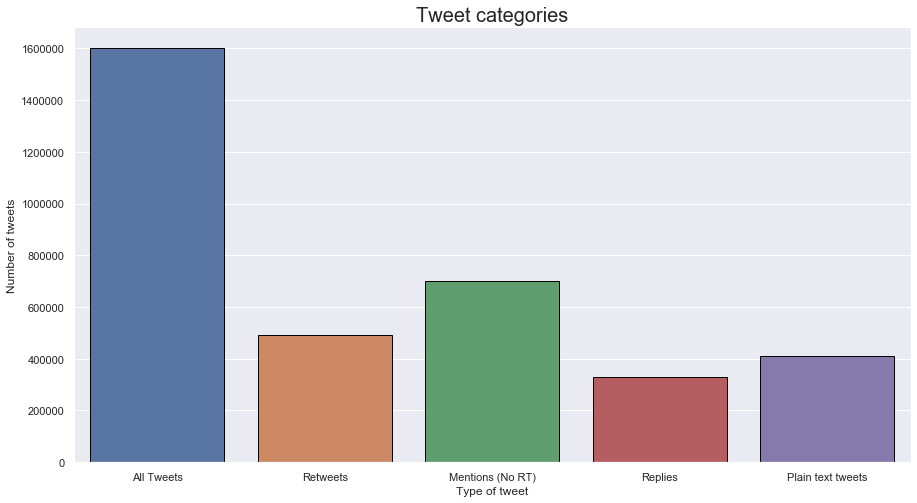

In [53]:
len_list = [ len(tweets), len(RT_tweets),len(mention_tweets), len(reply_tweets), len(plain_txt_tweets)]
item_list = ['All Tweets','Retweets', 'Mentions (No RT)', 'Replies', 'Plain text tweets']
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
plt.title('Tweet categories', fontsize = 20)
plt.xlabel('Type of tweet')
plt.ylabel('Number of tweets')
sns.barplot(x = item_list, y = len_list,  edgecolor = 'black', linewidth=1)

plt.show()

___

## Hashtags

In [57]:
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets['text'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

Making a list of the most used hashtags and their values

In [58]:
hashtag_ordered_dict =sorted(hashtag_dict.items(), key=lambda x:x[1])
hashtag_ordered_dict = hashtag_ordered_dict[::-1]
hashtag_ordered_dict

[('#EleccionesChile', 47643),
 ('#Tolerancia', 34300),
 ('#Elecciones', 33690),
 ('#Pi', 31524),
 ('#DebateAnatel', 24678),
 ('#ChileElige', 23826),
 ('#LasCarasDeLaMoneda', 22825),
 ('#Guillier', 22632),
 ('#VotaChile', 11609),
 ('#GuillierPresidente', 9652),
 ('#YoVotoGuillier', 9175),
 ('#T', 9066),
 ('#GuillierGigante', 8296),
 ('#ChileVota', 6874),
 ('#Chile', 6396),
 ('#VotoAVoto', 5814),
 ('#UnidosGanaLaGente', 5510),
 ('#CooperativaVota', 5505),
 ('#VotoPi', 4905),
 ('#PresidenteGuillier', 4741),
 ('#EnBuenChileno', 4204),
 ('#ElPresidenteDeLaGente', 4066),
 ('#Vota', 4028),
 ('#ChileDecide', 3711),
 ('#GuillierConBachelet', 3691),
 ('#CandidatoLlegoTuHora', 3447),
 ('#Antofagasta', 3343),
 ('#YoS', 3137),
 ('#EnPRIMERAvotaPI', 3132),
 ('#AlejandroGuillierEnBV', 3116),
 ('#LasCarasdeLaMoneda', 3090),
 ('#Cadem', 2898),
 ('#ProgramaGuillier', 2821),
 ('#EnBuenChilenoPresidencial', 2685),
 ('#VotaGuillier', 2678),
 ('#tolerancia', 2543),
 ('#gratuidad', 2442),
 ('#Kast', 2376),
 

In [78]:
def get_key_value(key, dict):
    if key in dict:
        print (dict[key])
    else:
        print("Not in Dictionary")

In [79]:
key = '#EleccionesChile'
get_key_value(key, hashtag_dict)

47643


In [80]:
key = '#PiñeraPresidente'
get_key_value(key, hashtag_dict)

Not in Dictionary


In [81]:
key = '#Piñera'
get_key_value(key, hashtag_dict)

Not in Dictionary


In [83]:
key = '#Bettertimes'
get_key_value(key, hashtag_dict)

Not in Dictionary


In [84]:
key = '#Vote3'
get_key_value(key, hashtag_dict)

Not in Dictionary


In [85]:
key = '#ElPresidenteDeLaGente'
get_key_value(key, hashtag_dict)

4066


In [86]:
key = '#Guillier'
get_key_value(key, hashtag_dict)

22632


In [88]:
key = '#guillierpresidente'
get_key_value(key, hashtag_dict)

103


In [89]:
key = '#guillierdaconfianza'
get_key_value(key, hashtag_dict)

500


In [90]:
key = '#EleccionesChile'
get_key_value(key, hashtag_dict)

47643


In [93]:
key = '#Electiones2017'
get_key_value(key, hashtag_dict)

Not in Dictionary


Separating the hashtags and their values into two different lists

In [94]:
key = '#elections2017'
get_key_value(key, hashtag_dict)

Not in Dictionary


In [59]:
hashtag_ordered_values = []
hashtag_ordered_keys = []

Pick the 20 most used hashtags to plot

In [62]:
for item in hashtag_ordered_dict[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])

`Plotting a graph with the most used hashtags`

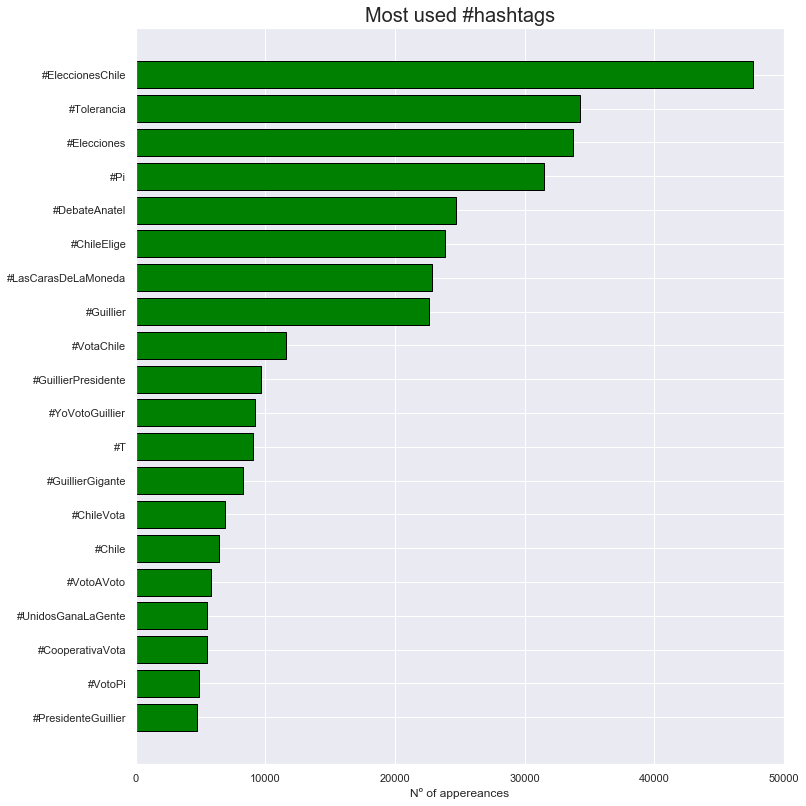

In [63]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Nº of appereances")
ax.set_title("Most used #hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

`Make a wordcloud plot of the most used hashtags, for this we need a dictionary where the keys are the words and the values are the number of appearances`

In [119]:
def word_cloud(wd_list):
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        width=1600,
        height=800,
        random_state=21,
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

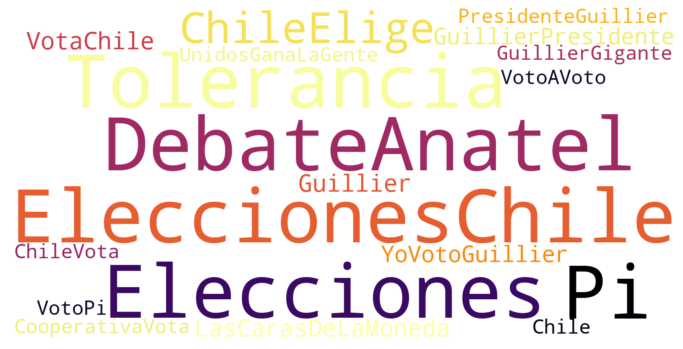

In [150]:
word_cloud(hashtag_ordered_keys)

 ## Mentions

In [100]:
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(tweets['text'].apply(mention_pattern.findall))
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1

In [101]:
mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1])
mentions_ordered_list = mentions_ordered_list[::-1]

In [102]:
mentions_ordered_list

[('@sebastianpinera', 476772),
 ('@guillier', 362753),
 ('@joseantoniokast', 72664),
 ('@Guillier', 47131),
 ('@mbachelet', 41409),
 ('@marcoporchile', 31470),
 ('@labeasanchez', 26383),
 ('@ceciliamorel', 24895),
 ('@carolinagoic', 19983),
 ('@biobio', 19815),
 ('@latercera', 19555),
 ('@supernovaf_', 18840),
 ('@GirealaDerecha', 18251),
 ('@cardenaldo', 16733),
 ('@T', 16037),
 ('@busdevel', 15774),
 ('@BeaSanchezYTu', 15687),
 ('@CristinaUna', 15657),
 ('@RoqueSagrado', 14879),
 ('@sergioulloa', 14170),
 ('@mjossandon', 14099),
 ('@EquipoKast', 14094),
 ('@Cooperativa', 14026),
 ('@Seawitch', 13632),
 ('@verito', 13366),
 ('@dgalarce', 13107),
 ('@HectorCamus', 13077),
 ('@sergmujica', 12917),
 ('@tolerancia', 12634),
 ('@LICAN', 12576),
 ('@CcarvajalA', 12552),
 ('@medicenelmono', 12506),
 ('@_pericopalotes', 12475),
 ('@QUILTROTOPITO', 12383),
 ('@zorrito_loino', 12366),
 ('@charlypapas', 12349),
 ('@jus', 12335),
 ('@jugogo', 12319),
 ('@claucortezm', 12315),
 ('@tv_monica', 1231

In [103]:
mentions_ordered_values = []
mentions_ordered_keys = []
for item in mentions_ordered_list[0:20]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])

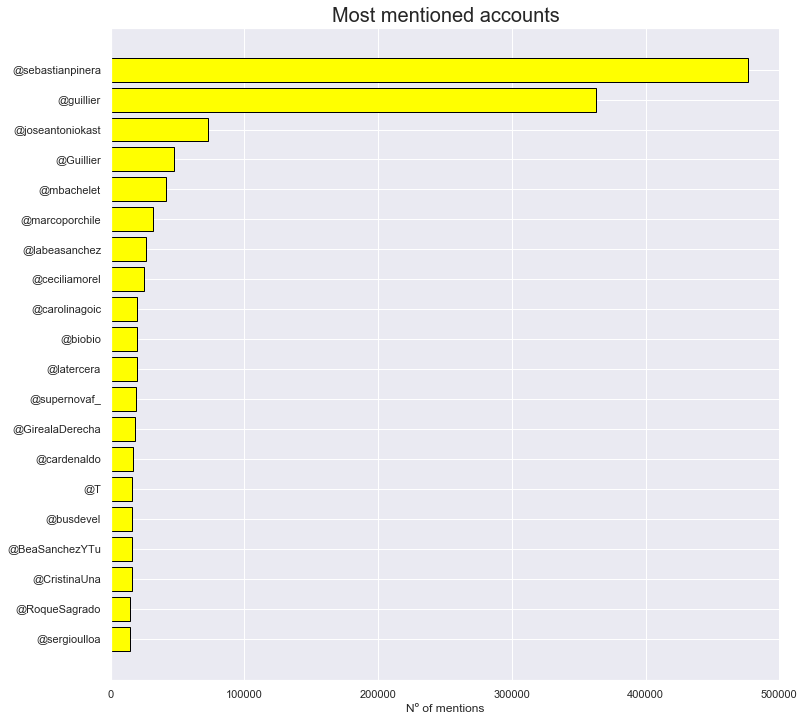

In [104]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(mentions_ordered_values))
ax.barh(y_pos ,list(mentions_ordered_values)[::-1], align='center', color = 'yellow', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos )
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_xlabel("Nº of mentions")
ax.set_title("Most mentioned accounts", fontsize = 20)

plt.show()

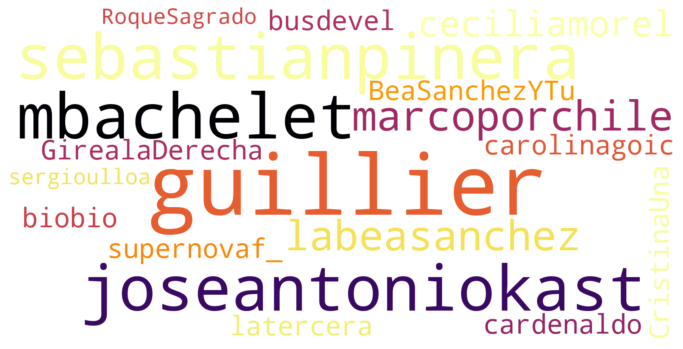

In [151]:
word_cloud(mentions_ordered_keys)

## Users 

In [106]:
print("There are {:,} different users".format(tweets['user'].nunique()))

There are 91,446 different users


`Lets take a look at the users who are posting these tweets:`

In [108]:
usertweets = tweets.groupby('user')

In [109]:
len(tweets.user.unique())

91446

In [110]:
#Taking the top 25 tweeting users
top_users = usertweets.count()['text'].sort_values(ascending = False)[:25]

In [54]:
top_users

user
joseantoniokast    25900
sergioulloa1       12403
biobio             12149
latercera          11632
T13                11166
Cooperativa        10983
baradit            10354
Emol                9198
adnradiochile       7942
pablolirar          6987
AlbertoMayol        6933
JovenesGuillier     6910
tjholt              6629
chelo_espinoza      6244
FelipeParadaM       5922
Chile_Alerta        5804
paulanarvaezo       5685
NachoOrtega         5529
mbachelet           5376
soychilecl          5350
robertoampuero      5332
marcatuvoto         5224
amarielgg           5086
albertoespina       5038
patricionavia       4564
Name: text, dtype: int64

In [111]:
top_users_dict = top_users.to_dict()
user_ordered_dict =sorted(top_users_dict.items(), key=lambda x:x[1])
user_ordered_dict = user_ordered_dict[::-1]

In [112]:
user_ordered_dict

[('joseantoniokast', 25820),
 ('sergioulloa1', 12360),
 ('biobio', 12137),
 ('latercera', 11562),
 ('T13', 11154),
 ('Cooperativa', 10971),
 ('baradit', 10354),
 ('Emol', 9178),
 ('adnradiochile', 7940),
 ('pablolirar', 6942),
 ('AlbertoMayol', 6930),
 ('JovenesGuillier', 6866),
 ('tjholt', 6623),
 ('chelo_espinoza', 6243),
 ('FelipeParadaM', 5919),
 ('Chile_Alerta', 5686),
 ('paulanarvaezo', 5684),
 ('NachoOrtega', 5526),
 ('soychilecl', 5349),
 ('robertoampuero', 5332),
 ('marcatuvoto', 5218),
 ('mbachelet', 5217),
 ('amarielgg', 5083),
 ('albertoespina', 5032),
 ('patricionavia', 4548)]

In [113]:
tweets[tweets['user'] == 'joseantoniokast'].device.value_counts()

-          12155
iPhone     11128
Web         1430
Android     1107
Name: device, dtype: int64

`@joseantoniokast tweet 373 tw/day ONLY from iphone and in total 863 post per day!!!!!!!`

In [114]:
tweets[tweets['user'] == 'T13'].device.value_counts()

-      10899
Web      255
Name: device, dtype: int64

`Now, like in the previous hashtags and mention cases, going to make two lists, one with the username and one with the value`

In [115]:
dict_values = []
dict_keys = []
for item in user_ordered_dict[0:25]:
    dict_keys.append(item[0])
    dict_values.append(item[1])

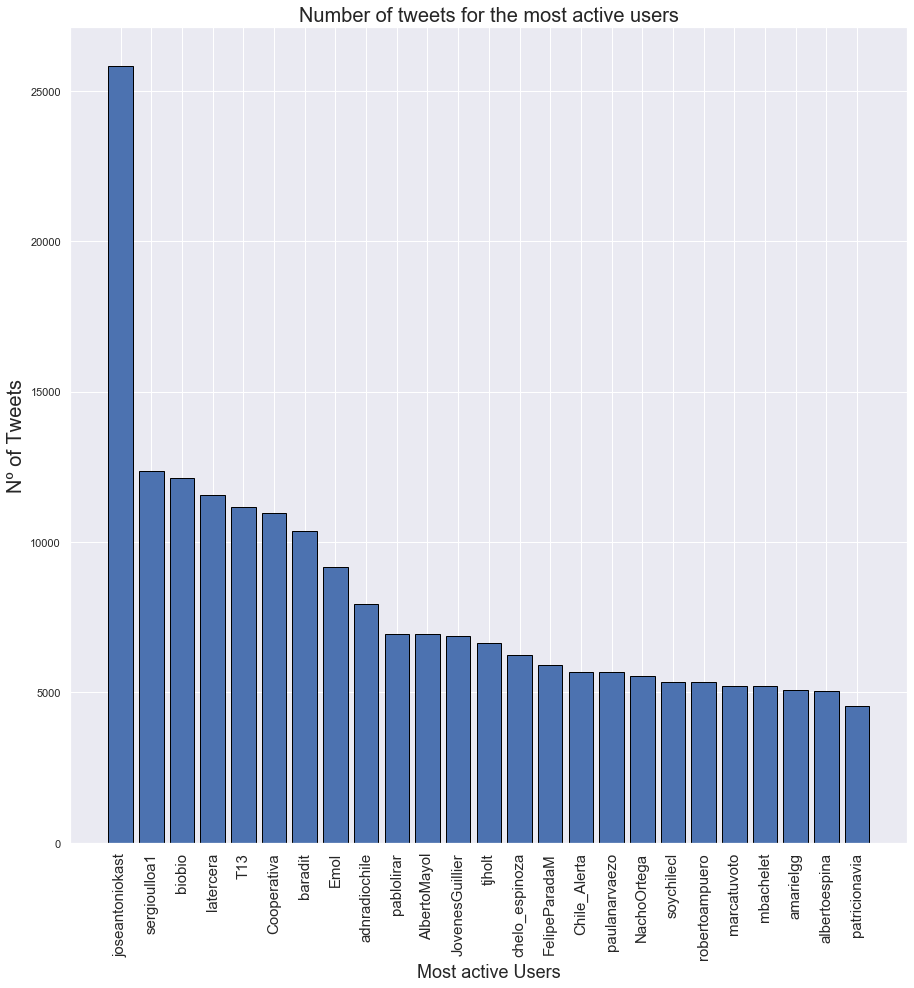

In [116]:
#Plot these results
fig = plt.figure(figsize = (15,15))
index = np.arange(25)
plt.bar(index, dict_values, edgecolor = 'black', linewidth=1)
plt.xlabel('Most active Users', fontsize = 18)
plt.ylabel('Nº of Tweets', fontsize=20)
plt.xticks(index,dict_keys, fontsize=15, rotation=90)
plt.title('Number of tweets for the most active users', fontsize = 20)
plt.savefig('Tweets_of_active_users.jpg')
plt.show()

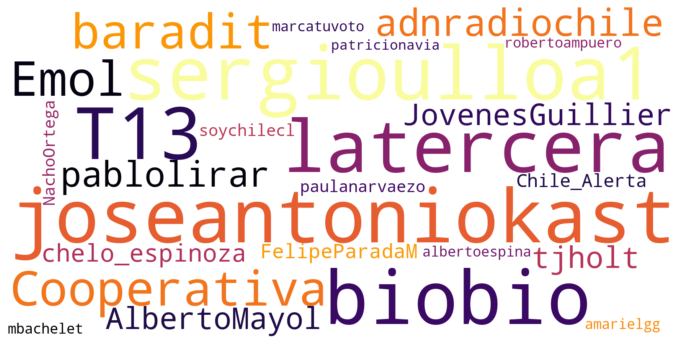

In [152]:
word_cloud(dict_keys)

## Non Verified users:

In [123]:
tw_no_verif = tweets[tweets.verified == False]
print(f"The percentage of tweets from non verified users is {round(len(tw_no_verif)/len(tweets)*100)}% of all the tweets")

The percentage of tweets from non verified users is 88% of all the tweets


In [124]:
print("There are {:,} different non verified users".format(tw_no_verif['user'].nunique()))

There are 91,268 different non verified users


In [125]:
nv_usertweets = tw_no_verif.groupby('user')
nv_top_users = nv_usertweets.count()['text'].sort_values(ascending = False)[:25]

nv_top_users_dict = nv_top_users.to_dict()
nv_user_ordered_dict =sorted(nv_top_users_dict.items(), key=lambda x:x[1])
nv_user_ordered_dict = nv_user_ordered_dict[::-1]
nv_user_ordered_dict

[('sergioulloa1', 12360),
 ('pablolirar', 6942),
 ('AlbertoMayol', 6930),
 ('chelo_espinoza', 6243),
 ('Chile_Alerta', 5686),
 ('NachoOrtega', 5526),
 ('soychilecl', 5349),
 ('robertoampuero', 5332),
 ('marcatuvoto', 5218),
 ('amarielgg', 5083),
 ('albertoespina', 5032),
 ('rbascu1', 4356),
 ('el_dinamo', 3837),
 ('corrupcionchile', 3623),
 ('waldocarrasco', 3366),
 ('ceciperez1', 3275),
 ('paulfontaineb', 3271),
 ('manuelotec', 3271),
 ('GiorgioJackson', 3144),
 ('DigitalGuillier', 3133),
 ('andres20ad', 3060),
 ('miguelhuerta32', 3023),
 ('PiensaPrensa', 2979),
 ('thecliniccl', 2816),
 ('supernovaf_1000', 2810)]

In [73]:
nv_dict_values = []
nv_dict_keys = []
for item in nv_user_ordered_dict[0:25]:
    nv_dict_keys.append(item[0])
    nv_dict_values.append(item[1])

`Now we will see the probabilities of each of the users being a bot #using the BOTOMETER API:`

In [235]:
import botometer
import tweepy

In [236]:
mashape_key = 'botomer_mashape_key'
twitter_app_auth = {
    'access_token' : "twitter_acc_access_token",
    'access_token_secret' : "twitter_acc_access_token_secret",
    'consumer_key' : "twitter_acc_consumer_key",
    'consumer_secret' : "twitter_acc_consumer_secret",    
}

`Connecting to the botometer API`

In [237]:
bom = botometer.Botometer(wait_on_ratelimit = True, mashape_key = mashape_key, **twitter_app_auth)

`Returns a dictionary with the most active users and the porcentage of likeliness of them bein a Bot using botometer`

In [74]:
nv_bot_dict = {}
nv_top_users_list = nv_dict_keys
for user in nv_top_users_list:
    user = '@'+ user
    try:
        result = bom.check_account(user)
        nv_bot_dict[user] = int((result['scores']['universal'])*100)
    except tweepy.TweepError:
        nv_bot_dict[user] = 'None'
        continue

In [75]:
nv_bot_dict

{'@sergioulloa1': 18,
 '@pablolirar': 23,
 '@AlbertoMayol': 2,
 '@chelo_espinoza': 4,
 '@Chile_Alerta': 25,
 '@NachoOrtega': 7,
 '@soychilecl': 22,
 '@robertoampuero': 5,
 '@marcatuvoto': 15,
 '@amarielgg': 31,
 '@albertoespina': 3,
 '@rbascu1': 14,
 '@el_dinamo': 6,
 '@corrupcionchile': 59,
 '@ceciperez1': 9,
 '@waldocarrasco': 8,
 '@manuelotec': 13,
 '@paulfontaineb': 3,
 '@DigitalGuillier': 'None',
 '@GiorgioJackson': 2,
 '@andres20ad': 25,
 '@miguelhuerta32': 25,
 '@PiensaPrensa': 18,
 '@thecliniccl': 7,
 '@supernovaf_1000': 'None'}

`Only 1 user '@corrupcionchile' with a Bot Score and 2 more that was blocked by Twitter nowadays (probably a bot back on 2017). `

## Timing analysis 

In [126]:
def giveday(timestamp):
    day_string = timestamp.day
    return day_string

In [127]:
tweets['day'] = tweets['created_at'].apply(giveday)
days = tweets.groupby('day')
daycount = days['text'].count()
timedict = daycount.to_dict()

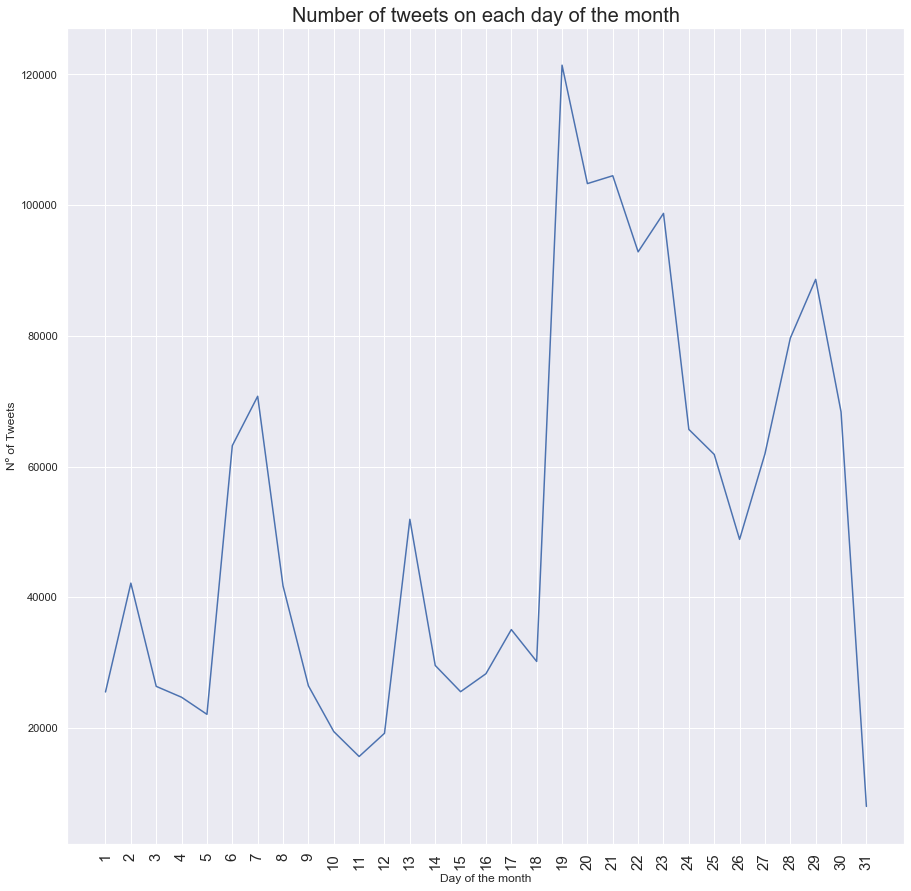

In [128]:
fig = plt.figure(figsize = (15,15))
plt.plot(list(timedict.keys()), list(timedict.values()))
plt.xlabel('Day of the month', fontsize = 12)
plt.ylabel('Nº of Tweets', fontsize=12)
plt.xticks(list(timedict.keys()), fontsize=15, rotation=90)
plt.title('Number of tweets on each day of the month', fontsize = 20)
plt.show()

`The pick day was Nov, 19th the day of first round`

## Devices 

`Now lets explore the different devices where the tweets are #produced from and plot these results`

In [129]:
devices = tweets.groupby('device')
devicecount = devices['text'].count()

`Same procedure as the for the mentions, hashtags, etc..`

In [130]:
device_dict = devicecount.to_dict()
device_ordered_list =sorted(device_dict.items(), key=lambda x:x[1])
device_ordered_list = device_ordered_list[::-1]
device_dict_values = []
device_dict_keys = []
for item in device_ordered_list:
    device_dict_keys.append(item[0])
    device_dict_values.append(item[1])

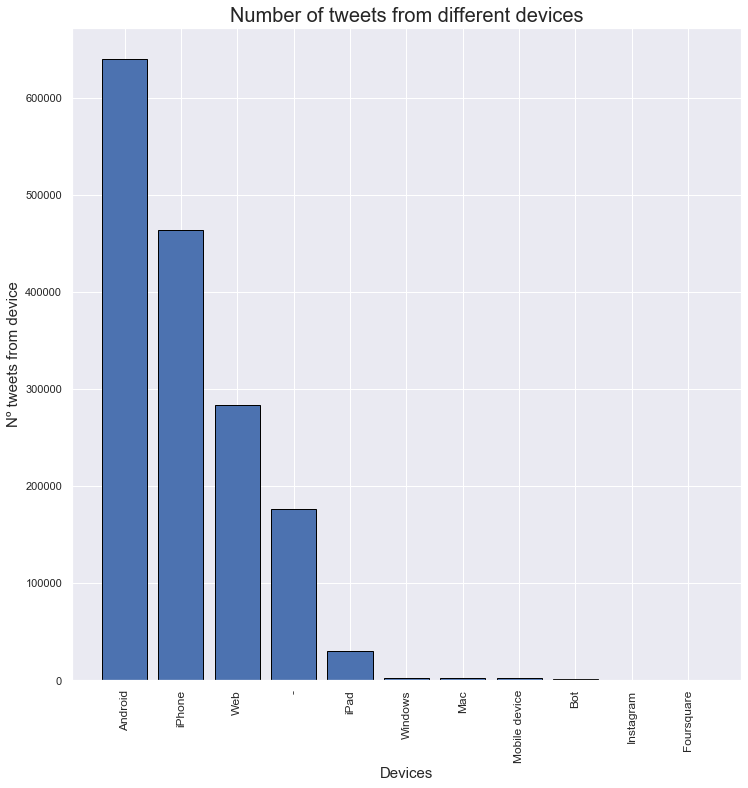

In [131]:
fig = plt.figure(figsize = (12,12))
index = np.arange(len(device_dict_keys))
plt.bar(index, device_dict_values, edgecolor = 'black', linewidth=1)
plt.xlabel('Devices', fontsize = 15)
plt.ylabel('Nº tweets from device', fontsize=15)
plt.xticks(index, list(device_dict_keys), fontsize=12, rotation=90)
plt.title('Number of tweets from different devices', fontsize = 20)

plt.show()

`The vast majority of tweets are generated by smartphones.`

In [133]:
len(tweets[tweets.device == 'Bot'])

1339

In [132]:
tweets[tweets.device == 'Bot'].user.value_counts()

Ivonomas           273
Patitoo_Verde      272
lushoibarra        239
Rnews9             124
AhorasNoticiaAN     90
defiendanos         57
jjorqueratt         47
cacem_express       45
KEILYG12            25
ChileReport         19
nicolashuss          8
VolcheRojo           8
AnyerlinB            7
ComuniCali           6
MiBitacoraBLOG       5
DavidReyDe           5
MasHallaDe           4
SaludNatural__       4
CatiGuerrilla        4
revolucionparat      4
AlbertoCMillanM      3
BMSElVenerable1      3
lavacamariposa1      3
angelittac           3
pacorro_garcia       3
dulcebofetada        3
VickMartinez91       2
ImpulsoInfo          2
PollosHermano53      2
questionforall       2
                  ... 
CarolinaRosus        1
p3laoaguilera        1
pedro_dm72           1
carlossalazarn       1
BeltranOvalle        1
cuentastwitte16      1
konductaizquier      1
Sauldj33             1
RinfoCHILE           1
CharlySaenz78        1
ElMarquesUnido       1
ValdesMiguelin       1
thk1211    

Also, some devices are classified as “Bot” (1,339 tweets) from 89 unique account users. Looking deeper, only few users generate more than 100 tweets during the month. The one of highest number of tweets (273) is @Ivonomas, a reporter that explicitly state on his profile that he will retweet automatically all tweets that mention him. So, this account is really a bot by definition (and officially accepted by Twitter), but out of our scope (bad social bots).  

## Clean Text

In [54]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt 

In [55]:
def pre_clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove hashtags (#xxx)
    lst = np.vectorize(remove_pattern)(lst, "#[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z]", " ")
    return lst

In [56]:
tweets['clean_text'] = pre_clean_tweets(tweets['text'])

In [138]:
from stop_words import get_stop_words

In [139]:
STOPWORDS = get_stop_words('spanish')

In [147]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='inferno',
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

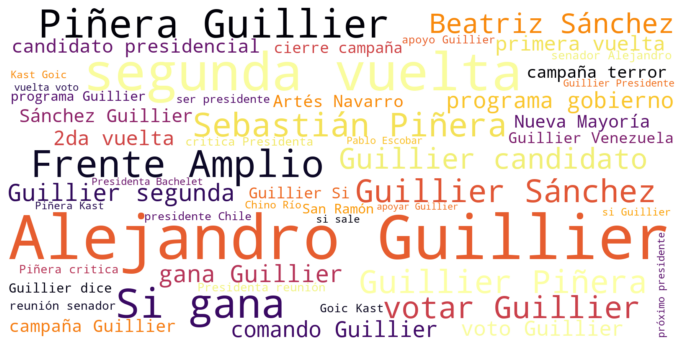

In [148]:
word_cloud(tweets['clean_text'])

## Saving final Tweet dataset

In [134]:
tweets.head(2)

,user_id,user,name,description,verified,protected,location,lang,followers,following,...,reply_to_user_id,device,RT,Reply,retweet_from,num_hashtags,num_mentions,num_urls,clean_text,day
0,24952459,T13,Tele13,Cuenta oficial de las plataformas informativas...,True,False,"Santiago, Chile",es,2837484,111381,...,nan,-,False,NaN,0,1,0,2,🔶 | Guillier presentará su programa de gobier...,31
1,2955687197,nostromar,Constanza Lewis,Defiendo a los animales del mundo y de mi país...,False,False,,es,3066,3386,...,nan,Android,True,NaN,@T13,1,1,2,🔶 | Guillier presentará su programa de gobie...,1


In [135]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1601643 entries, 0 to 1608084
Data columns (total 35 columns):
user_id               1601643 non-null int64
user                  1601643 non-null object
name                  1601576 non-null object
description           1601643 non-null object
verified              1601643 non-null bool
protected             1601643 non-null bool
location              1601643 non-null object
lang                  1601643 non-null object
followers             1601643 non-null int64
following             1601643 non-null int64
favourites            1601643 non-null int64
lists                 1601643 non-null int64
tweets_cnt            1601643 non-null int64
acc_creation          1601643 non-null datetime64[ns, UTC]
default_profile       1601643 non-null bool
default_prof_image    1601643 non-null bool
image                 1601643 non-null object
text                  1601643 non-null object
tweet_id              1601643 non-null int64
created_at     

In [136]:
tweets.to_csv("../data/30_tweets_nov_2017_final.csv")

---

## Text Similarities with Non-Verified Users posting original tweets (no RT)

### Test with Jaccard

In [163]:
def jaccard_similarity(cont1, cont2):
    cont1_simil= set(cont1.split())
    cont2_simil = set(cont2.split())
    intersection = cont1_simil.intersection(cont2_simil)
    return float(len(intersection)) / (len(cont1_simil) + len(cont2_simil) - len(intersection))    

In [170]:
tw1 = twts.clean_text[0]
tw2 = twts.clean_text[1]
jaccard_similarity(tw1, tw2)

0.4411764705882353

In [171]:
print("tw1: ", tw1)
print()
print("tw2: ",tw2)

tw1:     Para ti los que viven gracias a ley R Soto Bachelet es mucho mejor

tw2:  José Antonio Kast destrozó la candidatura de Guillier tras que este no presentara programa de gobierno.... 


` Time consuming on testing every tweet against all others will be huge! ` 

### Cosine Similarities

Based on https://github.com/heaven00/cosine_similarities

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [141]:
def find_relations(twts, feature_extraction, tdm):
    """
    Go through all the tweets and create a map for each tweet and
    there cosine similarities
    """
    # a list of dictionaries containing list of related tweets and the
    # cosine value
    cosine_value_map = []
    for tweet, user in zip(twts.clean_text, twts.user):
        temp = {user:[]}
        query = feature_extraction.transform([tweet])
        cosine_similarities = linear_kernel(query, tdm).flatten()
        related_docs_indices = cosine_similarities.argsort()[:-10:-1]
        for index in related_docs_indices:
            temp[user].append((twts.user[index], cosine_similarities[index], twts.clean_text[index]))
        cosine_value_map.append(temp)
    return cosine_value_map

In [142]:
twts = tweets[(tweets.RT == False) & (tweets.verified == False)].reset_index()

### Getting possible bots - day 1 

In [214]:
twts[twts.day == 1].user.nunique()

2972

In [143]:
def get_relations(twts):
    feature_extraction = TfidfVectorizer()
    tdm = feature_extraction.fit_transform(list(twts.clean_text))
    relations = find_relations(twts, feature_extraction, tdm)
    return relations

In [144]:
relations = get_relations(twts[twts.day == 1].reset_index())

In [181]:
data = {'user_one':[], 'user_two':[], 'cosine_relation':[], 'text':[]}
for item in relations:
    for key in item.keys():
        for processed_data in item[key]:
            if key != processed_data[0]:
                if processed_data[1] > 0.9:
                    data['user_one'].append(key)
                    data['user_two'].append(processed_data[0])
                    data['cosine_relation'].append(float(processed_data[1]))
                    data['text'].append(processed_data[2])
df = pd.DataFrame(data)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 4 columns):
user_one           1501 non-null object
user_two           1501 non-null object
cosine_relation    1501 non-null float64
text               1501 non-null object
dtypes: float64(1), object(3)
memory usage: 47.0+ KB


In [184]:
df.head(20)

,user_one,user_two,cosine_relation,text
0,Carlossassarini,notix_cl,1,Guillier: ?Calculamos 21 mil millones de dólar...
1,Carlossassarini,AhorasNoticiaAN,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
2,Carlossassarini,eugenioojeda3,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
3,Carlossassarini,notix_cl,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
4,Carlossassarini,ochapas,1,Guillier: “Calculamos 21 mil millones de dólar...
5,Carlossassarini,notix_cl,1,Guillier: ?Calculamos 21 mil millones de dólar...
6,Carlossassarini,AhorasNoticiaAN,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
7,Carlossassarini,eugenioojeda3,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
8,Carlossassarini,notix_cl,1,"Alejandro Guillier: ""Calculamos 21 mil millone..."
9,Carlossassarini,ochapas,1,Guillier: “Calculamos 21 mil millones de dólar...


In [185]:
user_dupl_1 = df.user_one
user_dupl_2 = df.user_two
user_dupl_un = set(user_dupl_1.append(user_dupl_2))

In [186]:
len(user_dupl_un)

133

In [188]:
from urllib.request import urlopen

In [189]:
url = "https://twitter.com/"

In [190]:
active_user = []
possible_bot_2 = []
for user in user_dupl_un:
    print(".", end='')
    try:
        html = urlopen(url+user).read()
        active_user.append(user) 
    except:
        possible_bot_2.append(user) 
    

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [191]:
len(active_user)

123

In [192]:
len(possible_bot_2)

10

In [193]:
possible_bot_2

['GBTS77',
 'RedEmergencyRNS',
 'Alexisl52349560',
 'micifuzza',
 'huskylobo',
 'DigitalGuillier',
 'Claudiopardoa',
 'lushoibarra',
 'AhorasNoticiaAN',
 'albatrosreales']

## Creating user oriented features dataset

In [153]:
def get_twts_per_day(tweets):
    tw_day = []
    for d in range (1, 31):
        tw_day.append(len(tweets[tweets.day == d]))
    return tw_day

In [154]:
def get_max_tweet_day(tweets, user_list):
    max_twt_day = []
    for user_name in user_list:
        t = tweets[tweets.user == user_name].reset_index(drop=True)
        twt_day = get_twts_per_day(t)
        max_twt_day.append(max(twt_day))
    max_tweet_day_user = dict(zip(user_list, max_twt_day))
    max_tweet_day_user = sorted(max_tweet_day_user.items(), key=lambda x:x[1], reverse=True)
    return max_tweet_day_user

In [505]:
get_max_tweet_day(tweets, possible_bot_2)

[('DigitalGuillier', 412),
 ('Claudiopardoa', 228),
 ('micifuzza', 45),
 ('huskylobo', 37),
 ('RedEmergencyRNS', 33),
 ('lushoibarra', 20),
 ('Alexisl52349560', 17),
 ('AhorasNoticiaAN', 17),
 ('GBTS77', 4),
 ('albatrosreales', 1)]

In [506]:
get_max_tweet_day(tweets, active_user)

[('EstoyConPinera', 848),
 ('el_dinamo', 682),
 ('soychilecl', 620),
 ('thecliniccl', 606),
 ('Makeka', 523),
 ('corrupcionchile', 522),
 ('etoledog', 282),
 ('medicenelmono', 268),
 ('fermin_ricardo', 266),
 ('pulso_tw', 238),
 ('Carlossassarini', 168),
 ('jandresgn', 166),
 ('notix_cl', 161),
 ('fredda1', 157),
 ('ZurdoCruzado', 133),
 ('GeminisRiquelme', 129),
 ('ColarteRodrigo', 110),
 ('mv_libre', 95),
 ('rogofe47Chile', 93),
 ('WenaChile', 92),
 ('palipaulina', 81),
 ('ingralej', 74),
 ('ingeconce66', 57),
 ('MismaDeSiempre', 55),
 ('jaimesponda', 54),
 ('Patitoo_Verde', 48),
 ('dixit_io', 46),
 ('UTOPICO_TOTAL', 41),
 ('Ivonomas', 40),
 ('RAUZARZURI', 35),
 ('eleotpeka', 34),
 ('psantandersala1', 33),
 ('libre_latina', 32),
 ('EGALVEZN', 31),
 ('fefaberry', 28),
 ('JPBENAVE', 28),
 ('Macaren39853135', 27),
 ('AraucaxGuillier', 25),
 ('Saldo_BIP', 25),
 ('soycalama', 25),
 ('martinezstenger', 23),
 ('AGUJON', 23),
 ('SEBASTIANVielma', 23),
 ('Rnews9', 22),
 ('filibertonunez', 21)

In [155]:
def verif_acc_active(user):
    url = "https://twitter.com/"
    try:
        html = urlopen(url+user).read()
        return True 
    except:
        return False

In [156]:
def get_hashtags(tweets):
    hashtags = []
    hashtag_pattern = re.compile(r"#[a-zA-Z]+")
    hashtag_matches = list(tweets['text'].apply(hashtag_pattern.findall))
    hashtag_dict = {}
    cnt = 0
    for match in hashtag_matches:
        for singlematch in match:
            if singlematch not in hashtag_dict.keys():
                hashtag_dict[singlematch] = 1
                cnt +=1
            else:
                hashtag_dict[singlematch] = hashtag_dict[singlematch]+1
                cnt +=1
    hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1], reverse=True)
    return hashtag_ordered_list, len(hashtag_ordered_list), cnt

In [157]:
def get_mentions(tweets):
    mentions = []
    mention_pattern = re.compile(r"@[a-zA-Z_]+")
    mention_matches = list(tweets['text'].apply(mention_pattern.findall))
    mentions_dict = {}
    cnt = 0
    for match in mention_matches:
        for singlematch in match:
            if singlematch not in mentions_dict.keys():
                mentions_dict[singlematch] = 1
                cnt +=1
            else:
                mentions_dict[singlematch] = mentions_dict[singlematch]+1
                cnt +=1
    mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1], reverse=True)
    return mentions_ordered_list, len(mentions_ordered_list), cnt

In [158]:
def print_user_features(tweets, user_name, prt=True, ver_act=False): 
    if ver_act == True:
        active_acc = verif_acc_active(user_name)
    else:
        active_acc = "Not checked" 
        
    t = tweets[tweets.user == user_name].reset_index(drop=True)

    user =  t.user.values[0]
    name = t.name.values[0]
    user_id = t.user_id.values[0]
    default_prof_image = t.default_prof_image.values[0]
    photo_url = t.image.values[0]
    acc_verif = t.verified.values[0]
    location = t.location.values[0]
    default_profile = t.default_profile.values[0]
    descr = t.description.values[0]  
    tws_cnt = t.tweets_cnt.values[0]
    frs_cnt = t.following.values[0]
    fols_cnt = t.followers.values[0]
    fav_cnt = t.favourites.values[0]
    
    if location == '': 
        local_bol = False
    else:
        local_bol = True
    
    if descr == '':
        descr_bol = False
    else:
        descr_bol = True
    
    tweets_analysed = len(t)
    
    last_tweet_date = t.created_at.values[-1]
    older_tweet_date = t.created_at.values[0]
    account_created_date = t.acc_creation.values[0]
    
    delta = last_tweet_date - account_created_date
    days = delta.astype('timedelta64[D]')
    account_age_days = days / np.timedelta64(1, 'D')
    
    recent_delta = last_tweet_date - older_tweet_date
    days = recent_delta.astype('timedelta64[D]')
    recent_age_days = days / np.timedelta64(1, 'D')  
    
    ave_acc_tw_day = round(tws_cnt/account_age_days, 2)
    ave_recent_tw_day = round(tweets_analysed/recent_age_days, 2)
    tw_day = get_twts_per_day(t)
    max_tweet_day = max(tw_day)

    if fav_cnt != 0:    
        rt_fv_idx = round(t.retweet_cnt.values[0]/fav_cnt, 2)
    else:
        rt_fv_idx = 0    
    
    if frs_cnt != 0:    
        fl_fw_idx = round(fols_cnt/frs_cnt, 2)
    else:
        fl_fw_idx = 0
    
    RT_tweets = t[t['RT'] == True]
    rt_tweets_cnt =  len(RT_tweets)   
    rt_ratio = round(rt_tweets_cnt/tweets_analysed*100)

    ment_tweets = t[t['num_mentions'] !=0]
    ment_tweets_cnt = len(ment_tweets)
    ment_ratio = round(ment_tweets_cnt/tweets_analysed*100)
    
    hash_tweets = t[t['num_hashtags'] !=0]
    hash_tweets_cnt = len(hash_tweets)
    hash_ratio = round(hash_tweets_cnt/tweets_analysed*100)
    
    mentions, unique_mentions_cnt, ment_cnt = get_mentions(t)
    hashtags, unique_hashtags_cnt, hash_cnt = get_hashtags(t)
    
    try:
        ment_idx = round(unique_mentions_cnt/ment_cnt, 2)
    except:
        ment_idx = 0.0
    try:
        hash_idx = round(unique_hashtags_cnt/hash_cnt, 2) 
    except:
        hash_idx = 0.0
        
    mean_urls = round(t.num_urls.values.mean(), 2)
    mean_lenght = round(t.lenght.values.mean(),0)
    
    metrics = [
        user, user_id, name, default_prof_image, photo_url, acc_verif, 
        location, local_bol, default_profile, descr, descr_bol, active_acc, tws_cnt, frs_cnt, 
        fols_cnt, fav_cnt, last_tweet_date, older_tweet_date, 
        tweets_analysed, account_age_days, ave_acc_tw_day, 
        ave_recent_tw_day, max_tweet_day, ment_tweets_cnt, hash_tweets_cnt, 
        unique_mentions_cnt, unique_hashtags_cnt, ment_idx, hash_idx, 
        rt_ratio, mean_urls, mean_lenght
    ]
    
    if prt == True:   
        print("\nInfo Data for @" + user)
        print("\nName:             ", name)
        print("User Id:          ", user_id)
        print("Default_Photo:    ", default_prof_image)
        print("Photo URL:)       ", photo_url)
        print("Acc Verified:     ", acc_verif)
        print("Has Location:     ", local_bol)
        print("Location:         ", location)
        print("default_profile:  ", default_profile)
        print("Has Description:  ", descr_bol)
        print("Description:      ", descr) 
        print("Account Active:   ", active_acc)

        print("\nNumber of Tweets analysed:         ", tweets_analysed)
        print("Last Tweet:                        ", last_tweet_date)
        print("Older Tweet Analysed:              ", older_tweet_date)
        print("Account Active age (in days)        {0:,}".format(account_age_days))
        print("Average recent tweets per day:      {}".format(ave_recent_tw_day))
        print("Maximun Recent Tweets Per Day:      {}".format(max_tweet_day))
        print("Average tweets per day since start: {}".format(ave_acc_tw_day))
        print("Total Tweets since start:           {0:,}".format(tws_cnt))
        print("Followers_count:                    {0:,}".format(fols_cnt))
        print("Friends_following_count             {0:,}".format(frs_cnt))
        print("Followers/Following_index:          {}".format(fl_fw_idx)) 
        print("Favourites (Like) count:            {0:,}".format(fav_cnt))       
        print("Retweet_Like_index:                 {}".format(rt_fv_idx)) 
        print("Retweet Ratio:                      {}%".format(rt_ratio))
        print("unique mentions cnt:                {}".format(unique_mentions_cnt)) 
        print("Mention Ratio:                      {}%".format(ment_ratio))
        print("Mention index:                      {}".format(ment_idx))
        print("unique hashtags cnt:                {}".format(unique_hashtags_cnt))     
        print("Hashtag Ratio:                      {}%".format(hash_ratio))
        print("Hashtag Index:                      {}%".format(hash_idx))
        print("Average URLs per tweet:             {}".format(mean_urls))
        print("Average text lenght per tweet:      {}".format(mean_lenght))
    
    return tw_day, metrics, mentions, hashtags

In [161]:
def get_info_data(user_name):
    tw_day, metrics, mentions, hastags = print_user_features(tweets, user_name, ver_act=True)
    print("\n \t[Tweets Sample] \n", tweets[(tweets.user == user_name)].text[:10])
    plt.title("@"+user_name+" - Number of Tweets per day", fontsize = 14)
    plt.bar(range(1, 31), tw_day);

### Testing functions


Info Data for @EstoyConPinera

Name:              Estoy Con Piñera
User Id:           840624094265643008
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/925539751607832576/JrNvNTD2_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   False
Has Description:   True
Description:       Comunidad de adherentes al candidato de Chile Vamos Sebastián Piñera.  #PiñeraPresidente
Account Active:    False

Number of Tweets analysed:          2678
Last Tweet:                         2017-11-30T16:21:47.000000000
Older Tweet Analysed:               2017-11-01T16:46:10.000000000
Account Active age (in days)        263.0
Average recent tweets per day:      95.64
Maximun Recent Tweets Per Day:      848
Average tweets per day since start: 2.14
Total Tweets since start:           564
Followers_count:                    5,040
Friends_following_count             2,536
Followers/Following_index:          1.99
Favourites (Lik

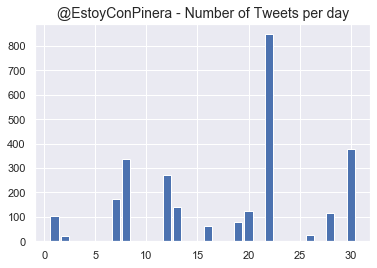

In [162]:
user_name = 'EstoyConPinera'
get_info_data(user_name)


Info Data for @el_dinamo

Name:              El Dínamo
User Id:           197473435
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/629289965709619200/ER8LQXFC_normal.png
Acc Verified:      False
Has Location:      True
Location:          Santiago, Chile
default_profile:   False
Has Description:   True
Description:       Infórmate y sé parte de @el_dinamo comentando en nuestra redes
Account Active:    True

Number of Tweets analysed:          3846
Last Tweet:                         2017-11-30T09:30:24.000000000
Older Tweet Analysed:               2017-11-01T04:00:26.000000000
Account Active age (in days)        2,616.0
Average recent tweets per day:      132.62
Maximun Recent Tweets Per Day:      682
Average tweets per day since start: 111.64
Total Tweets since start:           292,062
Followers_count:                    405,797
Friends_following_count             24,247
Followers/Following_index:          16.74
Favourites (Like) count:            1,63

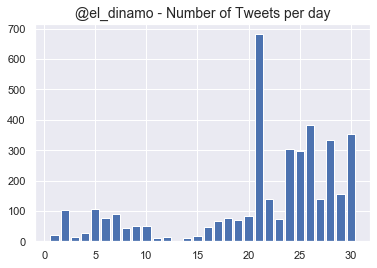

In [508]:
user_name = 'el_dinamo'
get_info_data(user_name)


Info Data for @GBTS77

Name:              GABRIEL TORO SALINAS
User Id:           962785885
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/917372928492212224/UCDlMt4G_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          S♡Y COMO QUIERO SER♥
default_profile:   False
Has Description:   False
Description:       
Account Active:    False

Number of Tweets analysed:          9
Last Tweet:                         2017-11-27T23:42:34.000000000
Older Tweet Analysed:               2017-11-01T14:03:49.000000000
Account Active age (in days)        1,832.0
Average recent tweets per day:      0.35
Maximun Recent Tweets Per Day:      4
Average tweets per day since start: 11.71
Total Tweets since start:           21,445
Followers_count:                    614
Friends_following_count             174
Followers/Following_index:          3.53
Favourites (Like) count:            12
Retweet_Like_index:                 0.0
Retweet Ratio:           

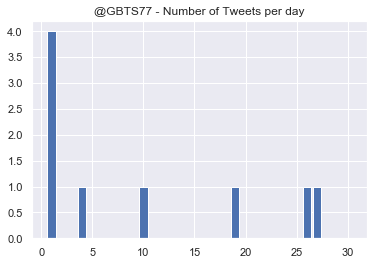

In [482]:
user_name = 'GBTS77'
get_info_data(user_name)


Info Data for @RedEmergencyRNS

Name:              RED EMERGENCIAS RNS
User Id:           721833486395555841
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/925412113631338496/HHiFemv5_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          📧📠 EmergenciasRNS@Gmail.com
default_profile:   True
Has Description:   True
Description:       Somos una ONG compuesta por 60 miembros a lo largo del país informando noticias de todo Chile.
Se parte de nuestra ONG y nuestro grupo de WhatsApp: +56949821754
Account Active:    False

Number of Tweets analysed:          234
Last Tweet:                         2017-11-28T16:01:18.000000000
Older Tweet Analysed:               2017-11-01T04:23:24.000000000
Account Active age (in days)        589.0
Average recent tweets per day:      8.67
Maximun Recent Tweets Per Day:      33
Average tweets per day since start: 67.62
Total Tweets since start:           39,827
Followers_count:                    908
Fr

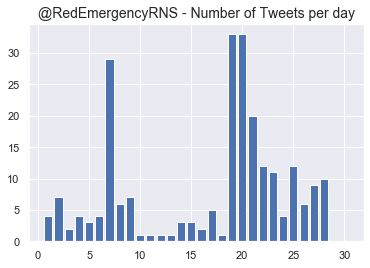

In [486]:
user_name = 'RedEmergencyRNS'
get_info_data(user_name)


Info Data for @Alexisl52349560

Name:              Alexis leon
User Id:           3385449707
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/903078267732844544/kXBZGMJs_normal.jpg
Acc Verified:      False
Has Location:      False
Location:          
default_profile:   True
Has Description:   True
Description:       la musica mi conexion ( soy guitarrista cantante ) ni izquierda ni derecha AMO la VIDA en todas sus formas PYME de automóviles 🚗
Account Active:    False

Number of Tweets analysed:          119
Last Tweet:                         2017-11-30T17:39:34.000000000
Older Tweet Analysed:               2017-11-01T01:05:30.000000000
Account Active age (in days)        863.0
Average recent tweets per day:      4.1
Maximun Recent Tweets Per Day:      17
Average tweets per day since start: 40.67
Total Tweets since start:           35,095
Followers_count:                    584
Friends_following_count             550
Followers/Following_index:          1

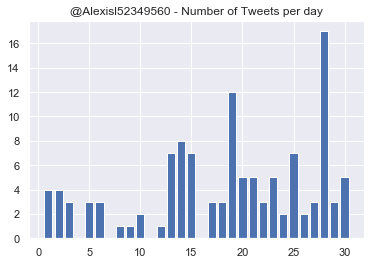

In [484]:
user_name = 'Alexisl52349560'
get_info_data(user_name)


Info Data for @micifuzza

Name:              Yany
User Id:           428471035
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/882021304391675907/LqUE6Y85_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   False
Has Description:   True
Description:       Profe de Lenguaje, admiro a quienes luchan por un Chile digno y abierto para todos,renunciando a intereses egoístas y a los acomodos del poder..
Account Active:    False

Number of Tweets analysed:          206
Last Tweet:                         2017-11-30T00:49:14.000000000
Older Tweet Analysed:               2017-11-01T23:05:51.000000000
Account Active age (in days)        2,187.0
Average recent tweets per day:      7.36
Maximun Recent Tweets Per Day:      45
Average tweets per day since start: 61.55
Total Tweets since start:           134,600
Followers_count:                    8,866
Friends_following_count             7,939
Followers/Following_in

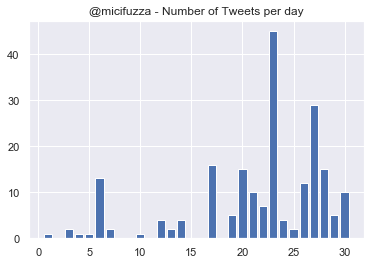

In [467]:
user_name = 'micifuzza'
get_info_data(user_name)


Info Data for @huskylobo

Name:              lobito
User Id:           32325247
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/477201421708697602/oJqDKoAH_normal.jpeg
Acc Verified:      False
Has Location:      False
Location:          
default_profile:   False
Has Description:   True
Description:       Opiniones de un ciudadano comun y corriente de Chile sobre cualquier tema de interes o de actualidad
Account Active:    False

Number of Tweets analysed:          341
Last Tweet:                         2017-11-29T21:36:48.000000000
Older Tweet Analysed:               2017-10-31T10:35:38.000000000
Account Active age (in days)        3,148.0
Average recent tweets per day:      11.76
Maximun Recent Tweets Per Day:      37
Average tweets per day since start: 11.48
Total Tweets since start:           36,130
Followers_count:                    613
Friends_following_count             981
Followers/Following_index:          0.62
Favourites (Like) count:       

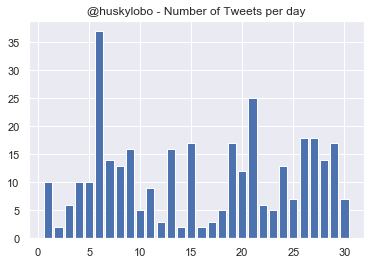

In [468]:
user_name = 'huskylobo'
get_info_data(user_name)


Info Data for @DigitalGuillier

Name:              TwiterosxGuillier
User Id:           864514655305289728
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/907336898779246599/7ZTuirnQ_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   False
Has Description:   True
Description:       Red de Twiteros por el candidato presidencial Alejandro Guillier @guillier #PresidenteDeLaGente
Account Active:    False

Number of Tweets analysed:          3144
Last Tweet:                         2017-11-30T11:37:02.000000000
Older Tweet Analysed:               2017-11-01T01:18:50.000000000
Account Active age (in days)        197.0
Average recent tweets per day:      108.41
Maximun Recent Tweets Per Day:      412
Average tweets per day since start: 17.24
Total Tweets since start:           3,396
Followers_count:                    2,891
Friends_following_count             570
Followers/Following_index:          5.07
Favo

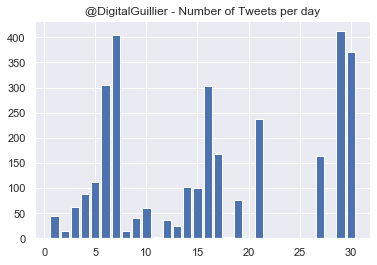

In [469]:
user_name = 'DigitalGuillier'
get_info_data(user_name)


Info Data for @Claudiopardoa

Name:              Claudio Pardo
User Id:           798152028795129856
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/881718290002956288/owUMtr4X_normal.jpg
Acc Verified:      False
Has Location:      False
Location:          
default_profile:   True
Has Description:   True
Description:       Emprendedor por naturaleza, en busca de un Chile con mas oportunidades para todos,en el cual se coloque a los mas vulnerables en primer lugar.
Me sigues te sigo
Account Active:    False

Number of Tweets analysed:          311
Last Tweet:                         2017-11-30T22:56:39.000000000
Older Tweet Analysed:               2017-11-01T00:43:02.000000000
Account Active age (in days)        381.0
Average recent tweets per day:      10.72
Maximun Recent Tweets Per Day:      228
Average tweets per day since start: 9.92
Total Tweets since start:           3,779
Followers_count:                    1,232
Friends_following_count           

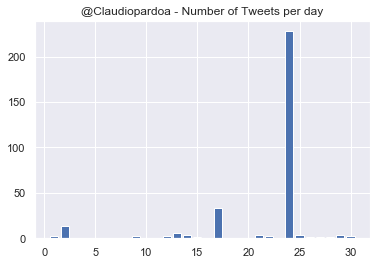

In [470]:
user_name = 'Claudiopardoa'
get_info_data(user_name)

In [218]:
twts.text[24225]

'@sebastianpinera @BegoBasauri @jumastorga @chechohirane @tomasgonzalez1 @alemustakis @nicolaslarrain @denissemalebran Brillante participación en TVN.\nVoto#3'


Info Data for @lushoibarra

Name:              Luis Ibarra Zagal
User Id:           4909400331
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/698903420963528705/e_fsKT6n_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Talca, Chile
default_profile:   False
Has Description:   True
Description:       Fui un patiperro del mundo, hoy un pobre asalariado radicado en el maule
De centro a la izquierda!
Account Active:    False

Number of Tweets analysed:          239
Last Tweet:                         2017-11-30T23:10:24.000000000
Older Tweet Analysed:               2017-11-01T04:11:24.000000000
Account Active age (in days)        655.0
Average recent tweets per day:      8.24
Maximun Recent Tweets Per Day:      20
Average tweets per day since start: 29.04
Total Tweets since start:           19,021
Followers_count:                    47
Friends_following_count             105
Followers/Following_index:          0.45
Favourites (

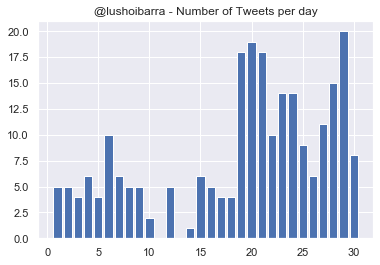

In [471]:
user_name = 'lushoibarra'
get_info_data(user_name)

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars



Info Data for @albatrosreales

Name:              Pia Alejandra
User Id:           852208184546795522
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/915382344579780610/lrBYUzrR_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Invernalia y Gotham
default_profile:   True
Has Description:   True
Description:       Depeche Mode 21/03/18. Mi conclusión eres sólo tú y una noche de Pet Shop Boys.
Account Active:    False

Number of Tweets analysed:          1
Last Tweet:                         2017-11-01T23:15:43.000000000
Older Tweet Analysed:               2017-11-01T23:15:43.000000000
Account Active age (in days)        203.0
Average recent tweets per day:      inf
Maximun Recent Tweets Per Day:      1
Average tweets per day since start: 17.64
Total Tweets since start:           3,581
Followers_count:                    94
Friends_following_count             95
Followers/Following_index:          0.99
Favourites (Like) count:

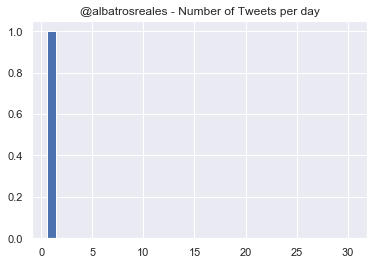

In [472]:
user_name = 'albatrosreales'
get_info_data(user_name)


Info Data for @AhorasNoticiaAN

Name:              Ahora Noticias
User Id:           887231332463595520
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/887233199331520512/sxoWoY88_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   True
Has Description:   True
Description:       Mantente informado al instante En ahoranoticias.cl

Únete a nuestra comunidad de Facebook: http://goo.gl/LTtgWI
Account Active:    False

Number of Tweets analysed:          90
Last Tweet:                         2017-11-30T21:00:33.000000000
Older Tweet Analysed:               2017-11-01T08:00:23.000000000
Account Active age (in days)        135.0
Average recent tweets per day:      3.1
Maximun Recent Tweets Per Day:      17
Average tweets per day since start: 52.76
Total Tweets since start:           7,122
Followers_count:                    79
Friends_following_count             417
Followers/Following_index:          0.19
F

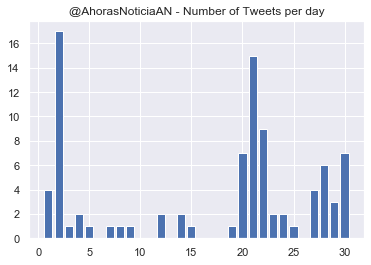

In [473]:
user_name = 'AhorasNoticiaAN'
get_info_data(user_name)


Info Data for @somos_guillier

Name:              #SomosGuillier
User Id:           860125660391641088
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/888490247432151041/rY7QZnGt_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   False
Has Description:   True
Description:       Red Ciudadana del Senador @guillier.
Account Active:    True

Number of Tweets analysed:          877
Last Tweet:                         2017-11-25T16:59:13.000000000
Older Tweet Analysed:               2017-11-01T00:00:01.000000000
Account Active age (in days)        205.0
Average recent tweets per day:      36.54
Maximun Recent Tweets Per Day:      121
Average tweets per day since start: 8.84
Total Tweets since start:           1,813
Followers_count:                    1,049
Friends_following_count             973
Followers/Following_index:          1.08
Favourites (Like) count:            7
Retweet_Like_index:              

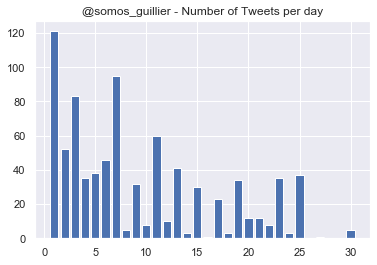

In [474]:
user_name = 'somos_guillier'
get_info_data(user_name)


Info Data for @Carlossassarini

Name:              CarlosSassarini
User Id:           161081949
Default_Photo:     False
Photo URL:)        http://pbs.twimg.com/profile_images/883838971675103234/7-_3m_QB_normal.jpg
Acc Verified:      False
Has Location:      True
Location:          Chile
default_profile:   False
Has Description:   True
Description:       Profesional de TI - Amante de la Naturaleza -  Firme defensor de Libertades- Jugador de Ajedrez
Account Active:    True

Number of Tweets analysed:          1306
Last Tweet:                         2017-11-30T23:57:09.000000000
Older Tweet Analysed:               2017-11-01T00:06:46.000000000
Account Active age (in days)        2,711.0
Average recent tweets per day:      45.03
Maximun Recent Tweets Per Day:      168
Average tweets per day since start: 52.65
Total Tweets since start:           142,723
Followers_count:                    3,886
Friends_following_count             998
Followers/Following_index:          3.89
Favourites (L

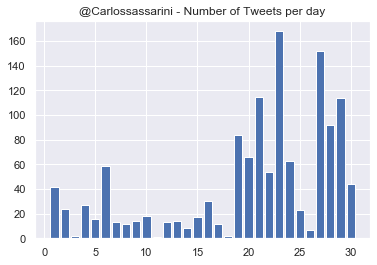

In [475]:
user_name = 'Carlossassarini'
get_info_data(user_name)

### Testing active users with Botometer 

In [231]:
def get_bot_prob(user):
    try:
        result = bom.check_account(user)
        sc_name = ((result['user']['screen_name']))
        score = int((result['score']['universal']) * 100)
        id = int((result['user']['id_str']))
        user = '@' + sc_name
        return result, user, id, score
    except:
        return 0, user, 0, 0

In [229]:
def get_botometer_details(user, prt = False):
    try:
        result = bom.check_account(user)
        score = result['scores']
        score_eng = score["english"]
        score_unl = score["universal"]
        cap = result['cap']
        cap_eng = cap["english"]
        cap_unl = cap["universal"]
        cat = result['categories'] 
        bt_friend = cat['friend']
        bt_network = cat['network'] 
        bt_sent = cat['sentiment'] 
        bt_temp = cat['temporal']
        bt_user = cat['user']   
        if print == True:
            print_botometer_details(result)
        return score_eng, score_unl, cap_eng, cap_unl, bt_friend, bt_network, bt_sent, bt_temp, bt_user
    except:
        if prt == True:
            print('{} is not a Twitter user or is blocked'.format(user))
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

In [230]:
def print_botometer_details(result):
    user_data = result['user']
    print("\nInfo Data for @" + user_data['screen_name'])
    print("User Id:     ", user_data["id_str"])
    score = result['scores']
    print("Score_eng:   ", score["english"])
    print("Score_unl:   ", score["universal"])
    cap = result['cap']
    print("CAP_eng:     ", cap["english"])
    print("CAP_unl:     ", cap["universal"])
    cat = result['categories'] 
    cat = result['categories'] 
    print('\nCategories:')
    print("Friend:     ", cat['friend'])
    print("Network:    ", cat['network'])   
    print("Sentiment:  ", cat['sentiment'])
    print("Temporal:   ", cat['temporal'])   
    print("User:       ", cat['user']) 

In [228]:
active_user

['RAUZARZURI',
 'ZurdoCruzado',
 'MismaDeSiempre',
 'IquiqueTheBest',
 'soychilecl',
 'gcca1969',
 'LysZarate',
 'javierschuler',
 'FalangeJuvenil',
 'alberto_acuna',
 'ulises120',
 'pdiazrieloff',
 'fefaberry',
 'JJimenezVillar',
 'notix_cl',
 'johannwegmann',
 'zitahofmann',
 'Cronica_Digital',
 'alejoarriaza',
 'Makeka',
 'NUBLEONLINE_',
 'EstoyConPinera',
 'JorgeMa80596210',
 'FotoAventura_',
 'albamaria777',
 'Paulinabozh',
 'ArturoPatagon73',
 'JoisMoas',
 'VicenteAmparo',
 'psantandersala1',
 'Carlossassarini',
 'angeldelacueca',
 'franrodrming',
 'aureliohugo',
 'fermin_ricardo',
 'el_dinamo',
 'ChileReport',
 'corrupcionchile',
 'SantiagoZodiak',
 'jaimesponda',
 'alvaroborquezm',
 'carito_guz',
 'IlustradoNot',
 'Ivonomas',
 'Tatiana43875954',
 'virginiaberrios',
 'libre_latina',
 'rogofe47Chile',
 'XimenaDelPIla12',
 'Armando95377928',
 'maitenmas',
 'CarmenBarraMor1',
 'EGALVEZN',
 'martinezstenger',
 'JPBENAVE',
 'chispop69',
 'currutias',
 'jeyzagus',
 'AraucaxGuillier',


In [238]:
user = 'RAUZARZURI'
result = bom.check_account(user)

In [233]:
result, user, id, score = get_bot_prob(user)

In [239]:
result

{'cap': {'english': 0.002856940094612955, 'universal': 0.0029102973297387607},
 'categories': {'content': 0.08569779607765933,
  'friend': 0.14231741345274818,
  'network': 0.11605549985132797,
  'sentiment': 0.05985886859558471,
  'temporal': 0.09392178145582956,
  'user': 0.05042452964186063},
 'display_scores': {'content': 0.4,
  'english': 0.4,
  'friend': 0.7,
  'network': 0.6,
  'sentiment': 0.3,
  'temporal': 0.5,
  'universal': 0.3,
  'user': 0.3},
 'scores': {'english': 0.07945465272791494, 'universal': 0.06565556198004287},
 'user': {'id_str': '123505158', 'screen_name': 'RAUZARZURI'}}

In [240]:
print_botometer_details(result)


Info Data for @RAUZARZURI
User Id:      123505158
Score_eng:    0.07945465272791494
Score_unl:    0.06565556198004287
CAP_eng:      0.002856940094612955
CAP_unl:      0.0029102973297387607

Categories:
Friend:      0.14231741345274818
Network:     0.11605549985132797
Sentiment:   0.05985886859558471
Temporal:    0.09392178145582956
User:        0.05042452964186063


## Saving User Metrics

In [514]:
# Creating a first data in metrics dataset
user_name = 'EstoyConPinera'
tw_day, metrics, mentions, hastags = print_user_features(tweets, user_name, prt = False, ver_act=True)
columns = [
        'user', 'user_id',  'name', 'default_prof_image', 'photo_url', 'acc_verif',
        'location', 'local_bol', 'default_profile', 'descr', 'descr_bol', 'active_acc',
        'tws_cnt', 'frs_cnt', 'fols_cnt', 'fav_cnt', 'last_tweet_date', 'older_tweet_date',
        'tweets_analysed', 'account_age_days', 'ave_acc_tw_day', 'ave_recent_tw_day',
        'max_tweet_day', 'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
        'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
        'mean_lenght'
    ]
dt = pd.DataFrame([metrics], columns=columns)
dt.to_csv('../data/features/10_user_metrics.csv', index=False)

In [512]:
def save_user_metrics(metrics):
    columns = [
        'user', 'user_id',  'name', 'default_prof_image', 'photo_url', 'acc_verif',
        'location', 'local_bol', 'default_profile', 'descr', 'descr_bol', 'active_acc',
        'tws_cnt', 'frs_cnt', 'fols_cnt', 'fav_cnt', 'last_tweet_date', 'older_tweet_date',
        'tweets_analysed', 'account_age_days', 'ave_acc_tw_day', 'ave_recent_tw_day',
        'max_tweet_day', 'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
        'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
        'mean_lenght'
    ]
    dt = pd.DataFrame([metrics], columns=columns)
    data = pd.read_csv('../data/features/10_user_metrics.csv')
    data = data.append(dt)
    data.to_csv('../data/features/10_user_metrics.csv', index=False)

In [519]:
users = tweets.user.unique()
len(users)

91549

In [524]:
for user_name in users:
    tw_day, metrics, mentions, hastags = print_user_features(tweets, user_name, prt = False, ver_act=True)
    print(".", end='')
    save_user_metrics(metrics)

..........

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


........................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1,2,3,4,5,6,9,10,11,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1,3,5,6,7,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


.

/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1,3,5,7,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................